# Sentiment Analysis and Hate-Speech Detection on Tweets

Todo General: 
- Add function generate_confusion_matrix(y_true, y_pred)
- Only apply data_cleaning once at the top of the notebook
- Run this on the entire training set... I don't know how long it will take...

Todo Naive Bayes: 
- Add validation set (like LSTM code) and perform hyperparameter tuning? 

Todo LSTM: 
- Reduce overfitting: Reduce the number of hidden units from 128 to between number of input units (50) and number of output classes (2), add dropout layers, etc. to reduce overfitting
- Use GLoVE embeddings to speed up training process? 

Todo VADER: 
- Debug why we're getting an error when using the evaluate function in apply_vader function

In [1]:
import pandas as pd
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from helper_functions import *
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## Sentiment Data EDA

In [2]:
df_sentiment=pd.read_csv('data/Sentiment140.csv', encoding='latin-1', header=None, index_col=False)
df_sentiment = df_sentiment[[0, 5]].rename(columns={0: "target", 5: "text"})
df_sentiment.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [3]:
df_sentiment.isnull().sum()

target    0
text      0
dtype: int64

In [4]:
# output the dataframe structure
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


<AxesSubplot: >

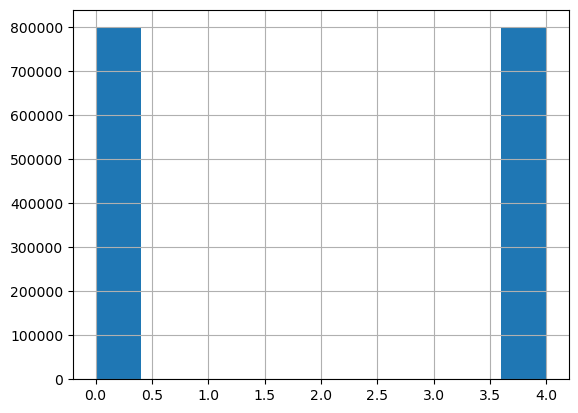

In [5]:
#Convert target to categorical
df_sentiment['target'] = pd.Categorical(df_sentiment.target)
df_sentiment['target'].unique()
df_sentiment['target'].hist()

In this dataset, target values describe the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive). However, there are only negative and positive tags (0 and 4) so let's change those values to 0 = negative, 1 = positive

<AxesSubplot: >

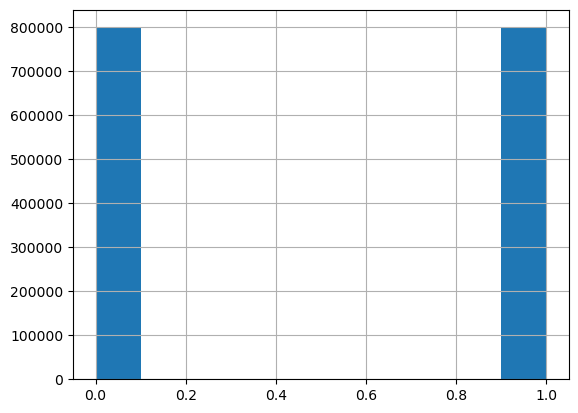

In [6]:
df_sentiment['target'] = df_sentiment['target'].replace(4,1) #Replace 4 (positive) by 1. Negative (0) remain the same
df_sentiment['target'].hist()

<AxesSubplot: >

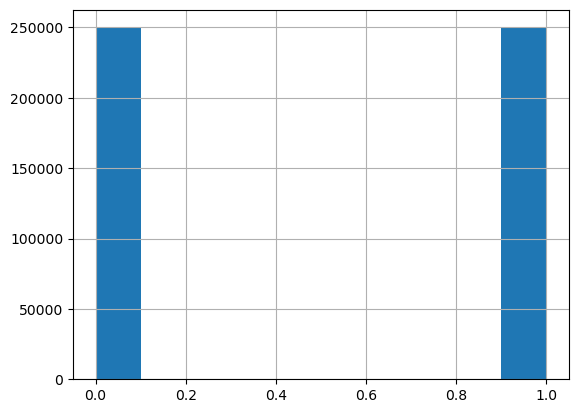

In [7]:
# For testing purposes, get a sample of the data
df_sentiment=df_sentiment.sample(500000)
df_sentiment['target'].hist()

## Hate Speech Data EDA

In [8]:
df_hate=pd.read_csv('data/HateSpeech_tweets.csv', encoding='latin-1', usecols  = ["class", "tweet"])
df_hate = df_hate.rename(columns={"class": "target", "tweet": "text"})
df_hate.head()

,target,text
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [9]:
df_hate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  24783 non-null  int64 
 1   text    24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [10]:
df_hate.isnull().sum()

target    0
text      0
dtype: int64

<AxesSubplot: >

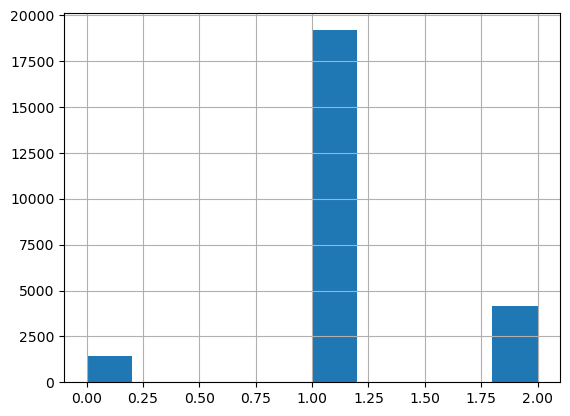

In [11]:
#Convert target to categorical
df_hate['target'] = pd.Categorical(df_hate.target)
df_hate['target'].unique()
df_hate['target'].hist()

UPDATE THIS IF WE ARE FINALLY KEEPING NON_OFFENSIVE TWEETS
In this dataset, target values describe the type of the tweet (0 - hate speech, 1 - offensive language, 2 - neither). However, for the desired task we are only interested in retrieving the hate speech and offensive language and identify a Negative Sentiment. Thus, we will remove the non-offensive text rows (tagged as 2-neither) and combine hate speech (0) and offensive language (1) into the same category 0, which is the value we used when traning the model to tag a Negative sentiment.

<AxesSubplot: >

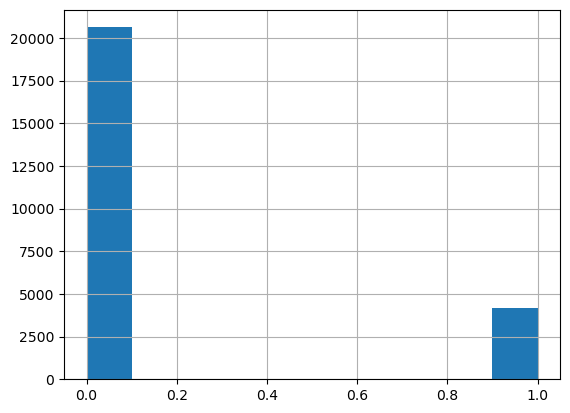

In [12]:
df_hate['target'] = df_hate['target'].replace(1,0) #Replace 1 (positive) by 0 to group hate speech and offensive language teweet into the same category
df_hate['target'] = df_hate['target'].replace(2,1) #Replace 1 (positive) by 0 to group hate speech and offensive language teweet into the same category
#df_hate = df_hate[df_hate['target'] == 0] #Keep only the rows with hate/offensive tweets
df_hate['target'].hist()

In [13]:
# Separate text from labels
X_hate=df_hate['text']
y_hate=df_hate['target']

## Train/ Test Split: Sentiment Data

In [14]:
# Split in training set and, testing set and separate labels from data
X_sentiment=df_sentiment['text']
y_sentiment=df_sentiment['target']
X_train, X_test, y_train, y_test=train_test_split(X_sentiment, y_sentiment, random_state = 0)

## Naive Bayes Model

### Preprocessing Sentiment Data

In [15]:
estimators=[('cleaner', FunctionTransformer(data_cleaning)), #TODO Add stop words param
            ('vectorizer', TfidfVectorizer(max_features=100000, ngram_range=(1, 2)))] #TODO Check these values
preprocessing_pipeline=Pipeline(estimators)

In [16]:
#Preprocess the training set
t1 = time.time()

X_train_transformed=preprocessing_pipeline.fit_transform(X_train)

t2 = time.time()
print(t2 - t1)

43.09549283981323


In [17]:
#Preprocess test set
t1 = time.time()

X_test_transformed=preprocessing_pipeline.transform(X_test)

t2 = time.time()
print(t2 - t1)

13.16940689086914


### Train Sentiment Model

In [18]:
# Create a Naive Bayes model and fit the training data
naive_bayes_model=MultinomialNB()
naive_bayes_model.fit(X_train_transformed, y_train)

MultinomialNB()

### Evaluate Sentiment Model

In [19]:
# Generate Predictions
nb_train_pred = naive_bayes_model.predict(X_train_transformed)
nb_test_pred = naive_bayes_model.predict(X_test_transformed)

In [20]:
# Evaluate the Naive Bayes model
print("Results: Naive Bayes Model - sentiment, training set")
evaluate(y_train, nb_train_pred)
print()
print("Results: Naive Bayes Model - sentiment, testing set")
evaluate(y_test, nb_test_pred)

Results: Naive Bayes Model - sentiment, training set
Accuracy: 0.8289813333333333
F1: 0.8267470634637619
Precision: 0.8375122466516697
Recall: 0.816255114397128

Results: Naive Bayes Model - sentiment, testing set
Accuracy: 0.79456
F1: 0.7915415212273724
Precision: 0.8018782585812734
Recall: 0.7814678869672539


### Hate Speech Detection with Naive Bayes Model

In [21]:
#Preprocess data
X_transformed=preprocessing_pipeline.transform(X_hate)

In [22]:
# Generate predictions
nb_hate_pred = naive_bayes_model.predict(X_transformed)

In [23]:
evaluate(y_hate, nb_hate_pred)

Accuracy: 0.539523060162208
F1: 0.31500600240096044
Precision: 0.20997039289429464
Recall: 0.6303146769156858


## LSTM 

In [24]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras import layers

### Preprocessing Sentiment Data

#### Cleaning

In [25]:
X=df_sentiment['text']
y=df_sentiment['target']

t1 = time.time()
X = data_cleaning(X)
t2 = time.time()
print(t2-t1)

43.03365206718445


#### Train/ Test Split

In [26]:
# Split in training set and, testing set and separate labels from data
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 0)

#### Preprocessing

In [27]:
tokenizer=Tokenizer() # change to the non-deprecated tf.keras.layers.TextVectorization 
tokenizer.fit_on_texts(X_train)
vocab_size=len(tokenizer.word_index)+1
print(f'Vocab Size: {vocab_size}')

Vocab Size: 186613


In [28]:
def lstm_preprocessing(X, y, tokenizer, maxlen = 40):
    X_processed = pad_sequences(tokenizer.texts_to_sequences(X), maxlen)
    y_processed = to_categorical(y)
    return (X_processed, y_processed)

# Apply preprocessing to train and validation sets
X_train_processed, y_train_processed = lstm_preprocessing(X_train, y_train, tokenizer)
X_val_processed, y_val_processed = lstm_preprocessing(X_val, y_val, tokenizer)

### Train Sentiment Model

In [29]:
model=Sequential()
model.add(layers.Embedding(input_dim=vocab_size,\
                           output_dim=50,\
                           input_length=40)) 
model.add(layers.Bidirectional(layers.LSTM(128))) #tried 48 to address overfitting
# model.add(layers.Dropout(0.4)) #added dropout layer to address overfitting
model.add(layers.Dense(2,activation='softmax'))
model.compile(optimizer='adam',\
              loss='categorical_crossentropy',\
              metrics=['accuracy'])

history = model.fit(X_train_processed,\
              y_train_processed,\
              batch_size=256,\
              epochs=3,\
              validation_data=(X_val_processed,y_val_processed))

2022-12-05 11:46:47.297007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/3
1099/1099 [==============================] - 164s 148ms/step - loss: 0.4643 - accuracy: 0.7792 - val_loss: 0.4288 - val_accuracy: 0.8004
Epoch 2/3
1099/1099 [==============================] - 157s 143ms/step - loss: 0.3350 - accuracy: 0.8553 - val_loss: 0.4718 - val_accuracy: 0.7869
Epoch 3/3
1099/1099 [==============================] - 156s 142ms/step - loss: 0.2301 - accuracy: 0.9056 - val_loss: 0.4986 - val_accuracy: 0.7876


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 50)            9330650   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              183296    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 9,514,460
Trainable params: 9,514,460
Non-trainable params: 0
_________________________________________________________________


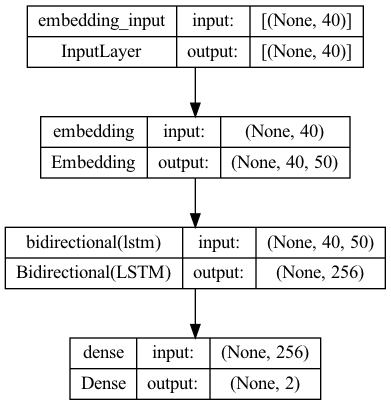

In [31]:
plot_model(model, 'test_plot.png', show_shapes=True)

### Evaluate Sentiment Model

In [32]:
# Preprocess test data
X_test_processed, y_test_processed = lstm_preprocessing(X_test, y_test, tokenizer)

In [35]:
# Generate predictions for sentiment data
predictions_sentiment = model.predict(X_test_processed)
predictions_sentiment = prediction_probs_to_target(predictions_sentiment)

3907/3907 [==============================] - 37s 9ms/step


In [36]:
# Evaluate test data
evaluate(y_test, predictions_sentiment)

Accuracy: 0.788176
F1: 0.7839447744630851
Precision: 0.7984475508202716
Recall: 0.7699594479796118


### Hate Speech Detection with LSTM Model

In [37]:
X_hate_cleaned = data_cleaning(X_hate)
X_hate_processed, y_hate_processed = lstm_preprocessing(X_hate_cleaned, y_hate, tokenizer)

In [38]:
predictions_hate = model.predict(X_hate_processed)
predictions_hate = prediction_probs_to_target(predictions_hate)

775/775 [==============================] - 7s 9ms/step


In [39]:
print(f"accuracy: {accuracy_score(y_hate, predictions_hate)}")
print(f"f1 score: {f1_score(y_hate, predictions_hate)}")
# evaluate(y_hate, predictions_hate)

accuracy: 0.5221724569261187
f1 score: 0.2753640925223351


## VADER

In [40]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt

According to the academic paper on VADER, the Valence score is measured on a scale from -4 to +4, where -4 stands for the most 'Negative' sentiment and +4 for the most 'Positive' sentiment. Let's set the following ranges for defining the polarity of the text:

- From -4 to 0: Negative --> 0
- From 0 to 4: Positive --> 1

In [41]:
def apply_vader(data, threshold = 0, plot = True, evaluate = True):
    analyzer = SentimentIntensityAnalyzer()
    data['vader'] = data.apply(lambda x: analyzer.polarity_scores(x['text'])['compound'], axis=1)
    if plot: 
        fig, ax = plt.subplots(figsize =(5, 3))
        ax.hist(data['vader'])
        plt.show()
    if evaluate: 
        data['predicted_target']=data.apply(lambda x: 0 if x['vader'] <= threshold else 1, axis=1)
        accuracy = accuracy_score(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        f1 = f1_score(data.dropna()["target"].values, data.dropna()["predicted_target"].values)
        # y_true = data.dropna()["target"].values
        # y_pred =  data.dropna()["predicted_target"].values
        # evaluate(y_true, y_pred)
        print(f'Accuracy: {accuracy}')    
        print(f'F1: {f1}')    

### VADER on Sentiment Data

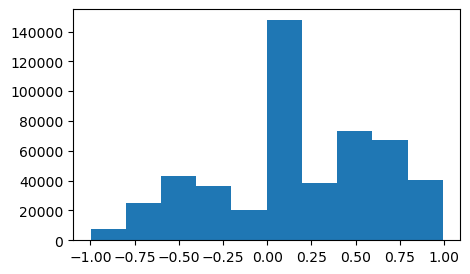

Accuracy: 0.652726
F1: 0.6430343835123605


In [42]:
df_vader_sentiment = df_sentiment
apply_vader(df_vader_sentiment)

### VADER on Hate Speech Data

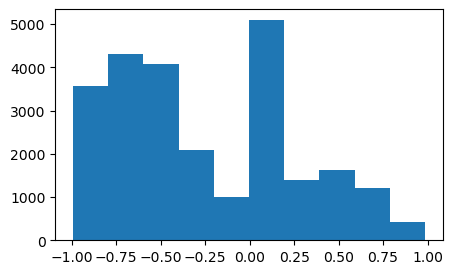

Accuracy: 0.7401041036194166
F1: 0.33823076132744273


In [43]:
df_vader_hate = df_hate 
apply_vader(df_vader_hate)